In [1]:
import sys
import os
import glob

import numpy  as np
import tables as tb
import pandas as pd

from collections import defaultdict


from invisible_cities.io                import dst_io                              as dstio
from invisible_cities.cities.components import get_event_info, get_pmt_wfs, WfType

import invisible_cities.cities.valdrada        as valdrada
import invisible_cities.core  .system_of_units as units


In [2]:
import matplotlib.pyplot as plt

### Useful parameters for plots
plt.rcParams["font.size"              ] = 15
plt.rcParams["figure.figsize"         ] = 10, 7.5
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.facecolor'       ] = 'w'
plt.rcParams['axes.facecolor'         ] = 'w'

### Config parameters

In [3]:
# General configuration

rn          = 8093
detector_db = 'new'#load_db.DetDB.new
file_in     = os.path.expandvars('$ICDIR/database/test_data/blr_fpga_examples.h5')

# Trigger configuration
qmin = 5000
qmax = 50000
wmin     = 2  * units.mus
wmax     = 40 * units.mus
base_dev = 10
amp_max  = 1000
pulse    = 50 * units.ns

pmt_conf = {0: {'q_min'           :     qmin, 'q_max'   :    qmax,
                'time_min'        :     wmin, 'time_max':    wmax,
                'baseline_dev'    : base_dev, 'amp_max' : amp_max,
                'pulse_valid_ext'   : pulse},
            2: {'q_min'           :     qmin, 'q_max'   :    qmax,
                'time_min'        :     wmin, 'time_max':    wmax,
                'baseline_dev'    : base_dev, 'amp_max' : amp_max,
                'pulse_valid_ext'   : pulse}}

trigger_config = {'coincidence_window':64, 'discard_width':0, 
                  'multipeak':None}

if trigger_config['multipeak'] is not None:
    trigger_config['multipeak']['time_min'  ] /= 25*units.ns
    trigger_config['multipeak']['time_after'] /= 25*units.ns
    
for k in pmt_conf.keys():
    pmt_conf[k]['time_min']       /= 25*units.ns
    pmt_conf[k]['time_max']       /= 25*units.ns
    pmt_conf[k]['pulse_valid_ext'] = int(pmt_conf[k]['pulse_valid_ext']/25*units.ns)

### Load pmt waveforms and apply BLR

In [4]:
rwf_to_cwf = valdrada.deconv_pmt_fpga(detector_db, rn, list(pmt_conf.keys()))

In [5]:
ievt = 6

with tb.open_file(file_in, "r") as h5in:
    evt_number = get_event_info  (h5in)[ievt][0]
    pmt_rwfs   = get_pmt_wfs     (h5in, WfType.rwf)[ievt]
    times_pmt  = np.linspace(0, 3200, pmt_rwfs.shape[1]+1)[:-1]  
    pmt_cwfs, baseline = rwf_to_cwf(pmt_rwfs)

#### Show result

/home/lior/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


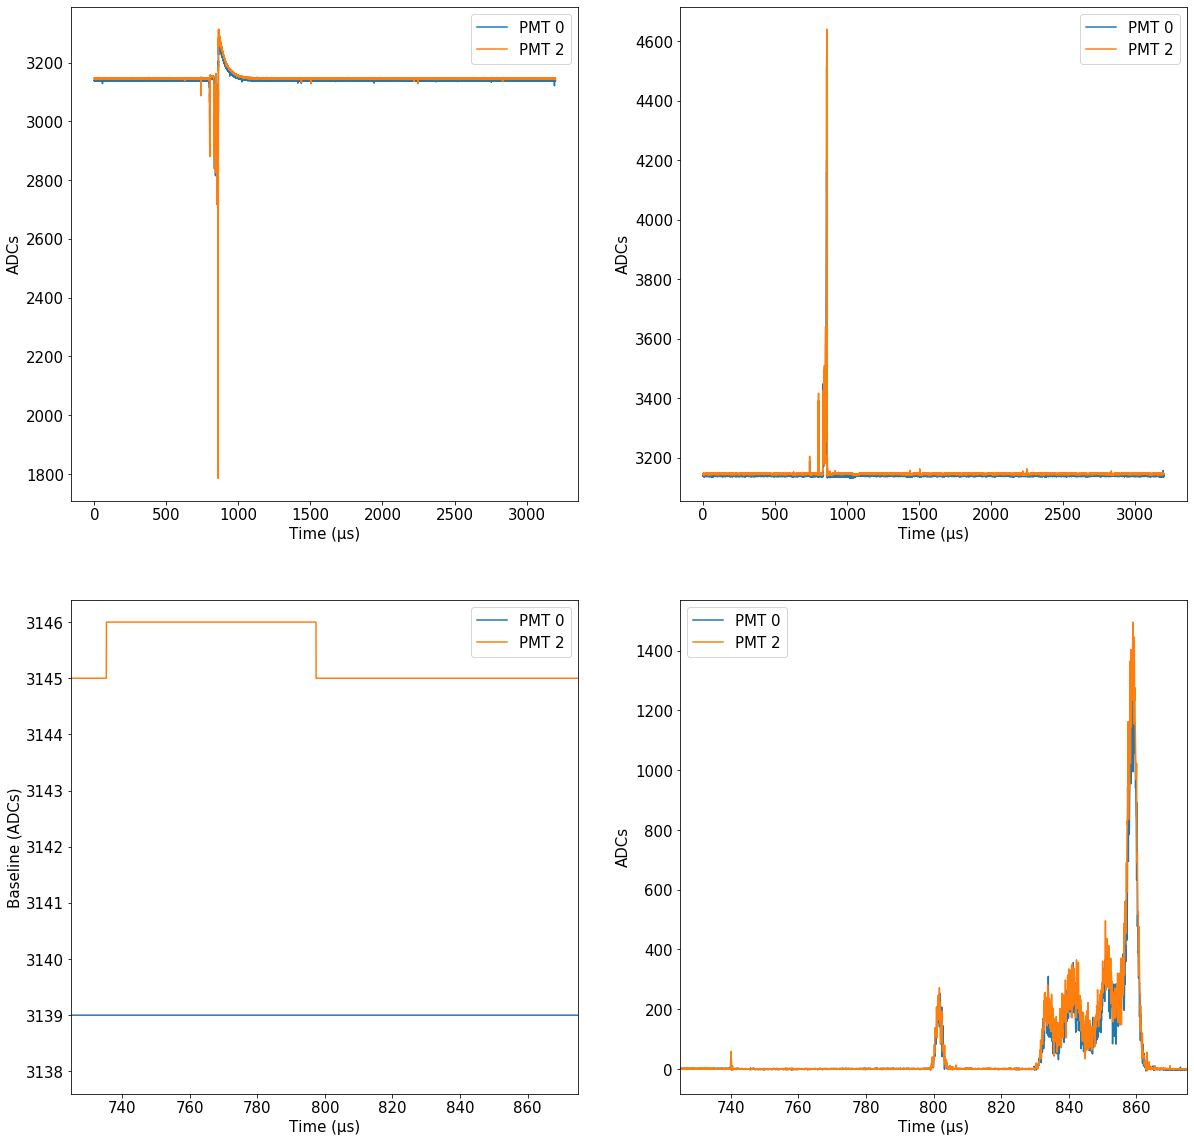

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes      = axes.flatten()
pmt_ids   = list(pmt_conf.keys())
for i, pmt_id in enumerate(pmt_ids):
    axes[0].plot(times_pmt, pmt_rwfs[pmt_id],               label=f'PMT {pmt_id}')
    axes[1].plot(times_pmt, pmt_cwfs[i     ],               label=f'PMT {pmt_id}')
    axes[2].plot(times_pmt, baseline[i     ],               label=f'PMT {pmt_id}')
    axes[3].plot(times_pmt, pmt_cwfs[i     ] - baseline[i], label=f'PMT {pmt_id}')
    
for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.legend()
    
axes[2].set_xlim(725, 875)
axes[3].set_xlim(725, 875)
axes[2].set_ylabel('Baseline (ADCs)');

### Look for triggers

In [7]:
get_triggers = valdrada.retrieve_trigger_information(pmt_conf, trigger_config)

In [8]:
triggers = get_triggers(pmt_rwfs, pmt_cwfs, baseline, evt_number)

#### Show results

Triggers are shown as vertical spans, green for valid triggers, red if not valid.

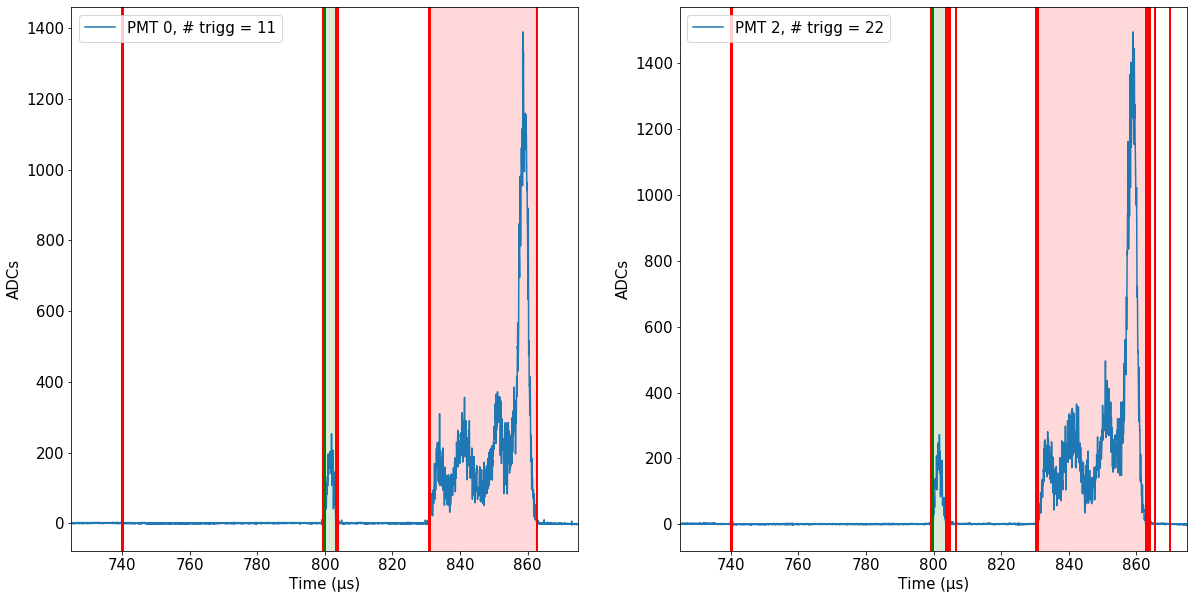

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, pmt_id in enumerate(pmt_ids):
    signal  = pmt_cwfs[i] - baseline[i]
    trigger = triggers[triggers[:, 1] == pmt_id]
    axes[i].plot(times_pmt, signal, label=f'PMT {pmt_id}, # trigg = {len(trigger)}')

    for t in trigger:
        [event       , pmt       ,
        trigger_time , charge    , width  , height    ,
        valid_q      , valid_w   , valid_h, valid_peak,
        mean_baseline, max_height, 
        n_coinc      , short     , shortpmt] = t
        valid_all = valid_q & valid_w & valid_h & valid_peak
        
        axes[i].axvspan(trigger_time*25/1000, (trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', alpha=.15)
        axes[i].axvline(trigger_time*25/1000, color= 'g' if valid_all else 'r', lw=2)
        axes[i].axvline((trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', lw=2)

for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.set_xlim(725, 875)    
    ax.legend()

### Look for triggers (increase discard width)

Increase discard width to reduce number of non-interesting candidates (produced by signal oscillations in the peak tails)

In [10]:
trigger_config = {'coincidence_window':64, 'discard_width':40, 
                  'multipeak':None}
get_triggers = valdrada.retrieve_trigger_information(pmt_conf, trigger_config)

In [11]:
triggers = get_triggers(pmt_rwfs, pmt_cwfs, baseline, evt_number)

#### Show results

Triggers are shown as vertical spans, green for valid triggers, red if not valid.

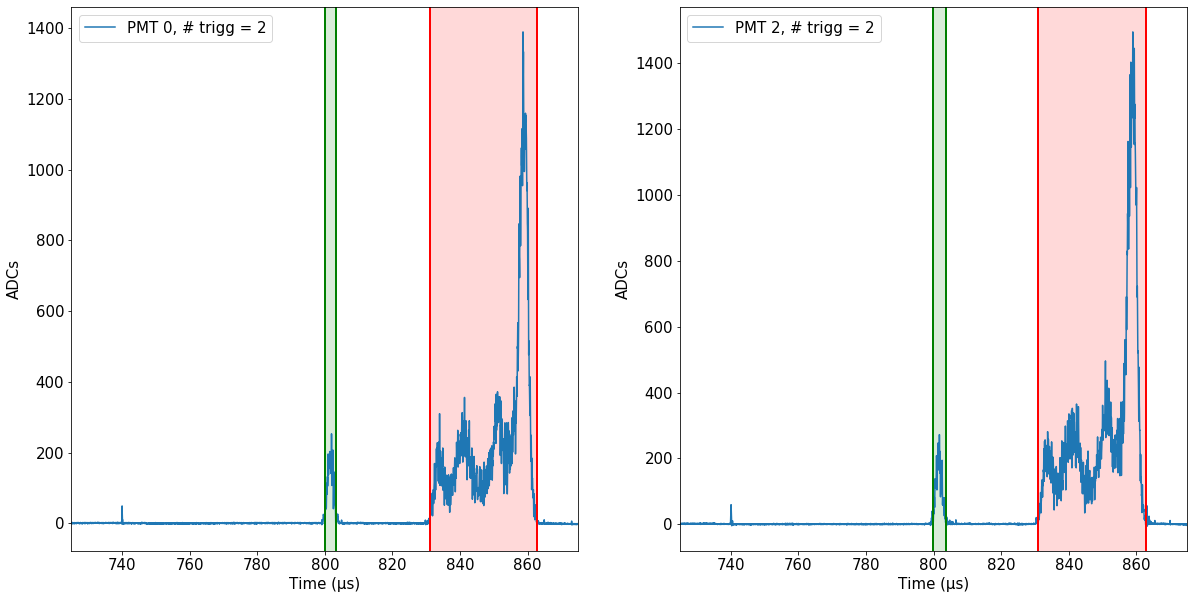

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, pmt_id in enumerate(pmt_ids):
    signal  = pmt_cwfs[i] - baseline[i]
    trigger = triggers[triggers[:, 1] == pmt_id]
    axes[i].plot(times_pmt, signal, label=f'PMT {pmt_id}, # trigg = {len(trigger)}')

    for t in trigger:
        [event       , pmt       ,
        trigger_time , charge    , width  , height    ,
        valid_q      , valid_w   , valid_h, valid_peak,
        mean_baseline, max_height, 
        n_coinc      , short     , shortpmt] = t
        valid_all = valid_q & valid_w & valid_h & valid_peak
        
        axes[i].axvspan(trigger_time*25/1000, (trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', alpha=.15)
        axes[i].axvline(trigger_time*25/1000, color= 'g' if valid_all else 'r', lw=2)
        axes[i].axvline((trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', lw=2)

for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.set_xlim(725, 875)    
    ax.legend()

### Look for triggers (multipeak protection)

Discard triggers if another peak is afterwards

In [13]:
trigger_config = {'coincidence_window':64, 'discard_width':40, 
                  'multipeak':{'q_min':100000, 'time_min':2*units.mus, 'time_after':800*units.mus}}
if trigger_config['multipeak'] is not None:
    trigger_config['multipeak']['time_min'  ] /= 25*units.ns
    trigger_config['multipeak']['time_after'] /= 25*units.ns
get_triggers = valdrada.retrieve_trigger_information(pmt_conf, trigger_config)

In [14]:
triggers = get_triggers(pmt_rwfs, pmt_cwfs, baseline, evt_number)

#### Show results

Triggers are shown as vertical spans, green for valid triggers, red if not valid. Since now there is a protection for later peaks, the previously valid trigger no longer is accepted.

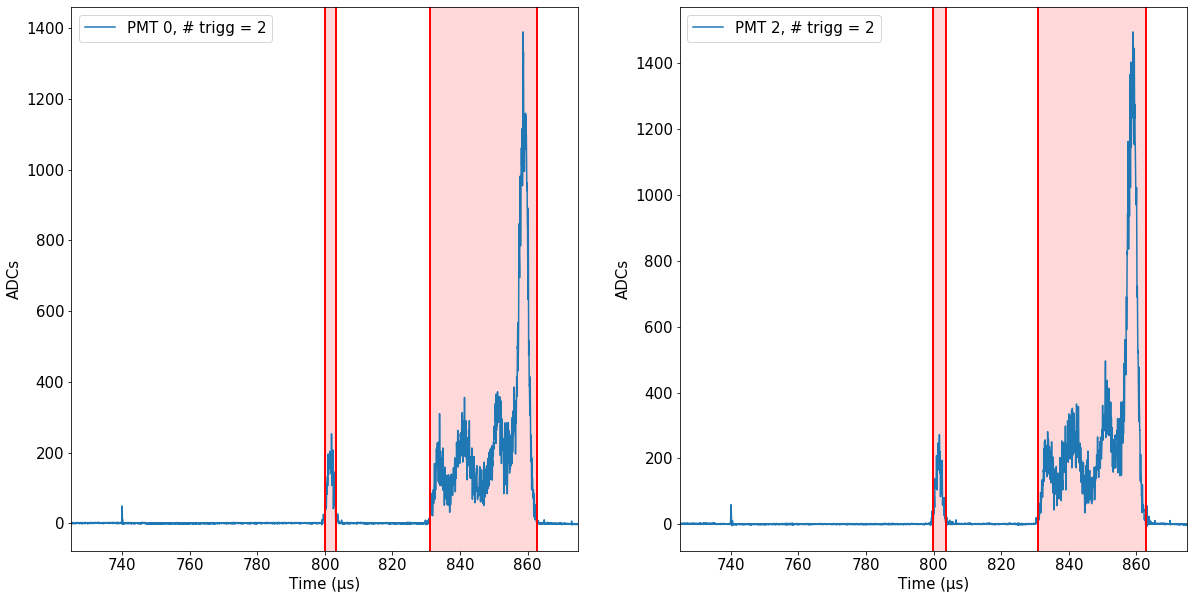

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, pmt_id in enumerate(pmt_ids):
    signal  = pmt_cwfs[i] - baseline[i]
    trigger = triggers[triggers[:, 1] == pmt_id]
    axes[i].plot(times_pmt, signal, label=f'PMT {pmt_id}, # trigg = {len(trigger)}')

    for t in trigger:
        [event       , pmt       ,
        trigger_time , charge    , width  , height    ,
        valid_q      , valid_w   , valid_h, valid_peak,
        mean_baseline, max_height, 
        n_coinc      , short     , shortpmt] = t
        valid_all = valid_q & valid_w & valid_h & valid_peak
        
        axes[i].axvspan(trigger_time*25/1000, (trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', alpha=.15)
        axes[i].axvline(trigger_time*25/1000, color= 'g' if valid_all else 'r', lw=2)
        axes[i].axvline((trigger_time + width)*25/1000, color= 'g' if valid_all else 'r', lw=2)

for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.set_xlim(725, 875)    
    ax.legend()

### Evaluate coincidences

Remove multipeak protection to have a valid trigger

In [16]:
trigger_config = {'coincidence_window':64, 'discard_width':40, 
                  'multipeak':None}
get_triggers       = valdrada.retrieve_trigger_information(pmt_conf, trigger_config)
check_coincidences = valdrada.check_trigger_coincidence(trigger_config['coincidence_window'])

In [17]:
triggers = get_triggers(pmt_rwfs, pmt_cwfs, baseline, evt_number)

In [18]:
trigger_coinc = check_coincidences(triggers)

#### Show results

Only the Kr triggers have a number of coincidences above 0 (as the higher energy peak triggers are considered not valid and thus not taken into account in the coincidence module). 
Since PMT0 trigger starts latter (see vertical line in figure), his number of coincidences is equal to 1 (himself) and no closest PMT is found. PMT2 finds PMT0 as the closest trigger.

Trigger 0 of PMT 0 has 1 coincidences, closest pmt is -1 at -1 tbins
Trigger 0 of PMT 0 has -1 coincidences, closest pmt is -1 at -1 tbins
Trigger 1 of PMT 2 has 2 coincidences, closest pmt is 0 at 2 tbins
Trigger 1 of PMT 2 has -1 coincidences, closest pmt is -1 at -1 tbins


/home/lior/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


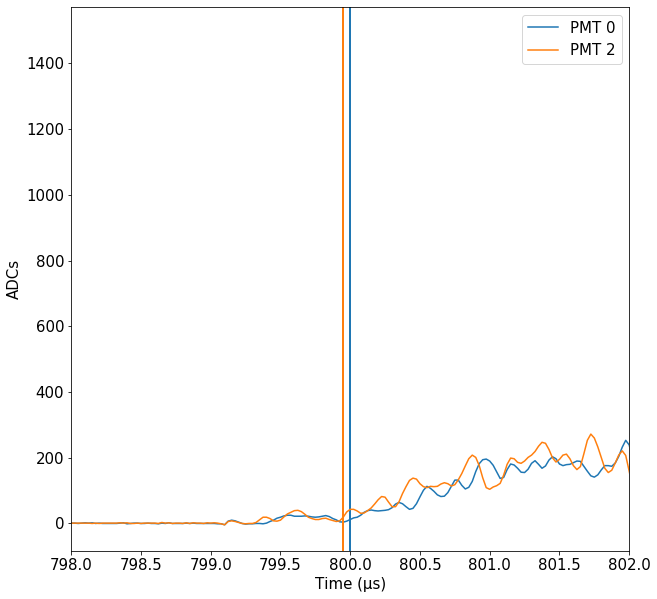

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes = [axes]
for i, pmt_id in enumerate(pmt_ids):
    signal  = pmt_cwfs[i] - baseline[i]
    trigger = trigger_coinc[triggers[:, 1] == pmt_id]
    axes[0].plot(times_pmt, signal, label=f'PMT {pmt_id}')

    for t in trigger:
        [event       , pmt       ,
        trigger_time , charge    , width  , height    ,
        valid_q      , valid_w   , valid_h, valid_peak,
        mean_baseline, max_height, 
        n_coinc      , short     , shortpmt] = t
        valid_all = valid_q & valid_w & valid_h & valid_peak
        
        axes[0].axvline(trigger_time*25/1000, color=f'C{i}', lw=2)
        print(f'Trigger {i} of PMT {pmt_id} has {t[-3]} coincidences, closest pmt is {t[-1]} at {t[-2]} tbins')

for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.set_xlim(798, 802)    
    ax.legend()

### Evaluate coincidences

Remove multipeak protection to have a valid trigger

In [20]:
trigger_config = {'coincidence_window':1, 'discard_width':40, 
                  'multipeak':None}
get_triggers       = valdrada.retrieve_trigger_information(pmt_conf, trigger_config)
check_coincidences = valdrada.check_trigger_coincidence(trigger_config['coincidence_window'])

In [21]:
triggers = get_triggers(pmt_rwfs, pmt_cwfs, baseline, evt_number)

In [22]:
trigger_coinc = check_coincidences(triggers)

#### Show results

Now, because the coincidence window is lower than the distance between triggers, it also states just one coincidence (itself) for PMT2. However, the information of the closest valid trigger is kept.

Trigger 0 of PMT 0 has 1 coincidences, closest pmt is -1 at -1 tbins
Trigger 0 of PMT 0 has -1 coincidences, closest pmt is -1 at -1 tbins
Trigger 1 of PMT 2 has 1 coincidences, closest pmt is 0 at 2 tbins
Trigger 1 of PMT 2 has -1 coincidences, closest pmt is -1 at -1 tbins


/home/lior/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


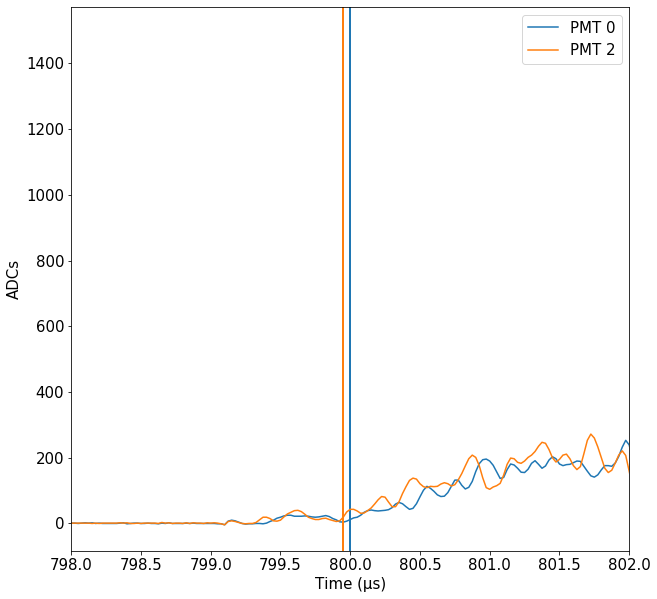

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes = [axes]
for i, pmt_id in enumerate(pmt_ids):
    signal  = pmt_cwfs[i] - baseline[i]
    trigger = trigger_coinc[triggers[:, 1] == pmt_id]
    axes[0].plot(times_pmt, signal, label=f'PMT {pmt_id}')

    for t in trigger:
        [event       , pmt       ,
        trigger_time , charge    , width  , height    ,
        valid_q      , valid_w   , valid_h, valid_peak,
        mean_baseline, max_height, 
        n_coinc      , short     , shortpmt] = t
        valid_all = valid_q & valid_w & valid_h & valid_peak
        
        axes[0].axvline(trigger_time*25/1000, color=f'C{i}', lw=2)
        print(f'Trigger {i} of PMT {pmt_id} has {t[-3]} coincidences, closest pmt is {t[-1]} at {t[-2]} tbins')

for ax in axes:
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('ADCs')
    ax.set_xlim(798, 802)    
    ax.legend()

### Execute the city

In [24]:
file_out = file_in+'_dummy.h5'
conf     = dict(files_in       = file_in,
                   file_out       = file_out,
                   event_range    = (6,7),
                   compression    = 'ZLIB4',
                   print_mod      = 1000,
                   run_number     = 8093,
                   trigger_config = dict(coincidence_window = 64
                                        ,discard_width      = 40
                                        ,multipeak          = None),
                   channel_config = {0 : dict(q_min           = 5000
                                                 ,q_max           = 50000
                                                 ,time_min        = 2 *units.mus
                                                 ,time_max        = 40*units.mus
                                                 ,baseline_dev    = 10
                                                 ,amp_max         = 1000
                                                 ,pulse_valid_ext = 50*units.ns)
                                    ,2 : dict(q_min           = 5000
                                                 ,q_max           = 50000
                                                 ,time_min        = 2 *units.mus
                                                 ,time_max        = 40*units.mus
                                                 ,baseline_dev    = 10
                                                 ,amp_max         = 1000
                                                 ,pulse_valid_ext = 50*units.ns)})

In [25]:
valdrada.valdrada(**conf)

events processed: 0, event number: 71


Namespace(events_in=1, events_out=1, events_pass=PassedFailed(n_passed=1, n_failed=0), evtnum_list=[71])

In [26]:
trigger_dst = dstio.load_dst(file_out, 'Trigger', 'DST')

In [27]:
trigger_dst

,event,pmt,trigger_time,q,width,height,valid_q,valid_w,valid_h,valid_peak,valid_all,baseline,max_height,n_coinc,closest_ttime,closest_pmt
0,71,0,32000,15635,130,253,True,True,True,True,True,3139,1854,1,-1,-1
1,71,0,33240,319838,1265,1390,False,True,False,True,False,3139,1854,-1,-1,-1
2,71,2,31998,17525,145,272,True,True,True,True,True,3145,1785,2,2,0
3,71,2,33240,379606,1269,1496,False,True,False,True,False,3145,1785,-1,-1,-1


In [28]:
### Now with multipeak protection on

In [29]:
file_out = file_in+'_dummy.h5'
conf     = dict(files_in       = file_in,
                   file_out       = file_out,
                   event_range    = (6,7),
                   compression    = 'ZLIB4',
                   print_mod      = 1000,
                   run_number     = 8093,
                   trigger_config = dict(coincidence_window = 64
                                        ,discard_width      = 40
                                        ,multipeak          = dict(q_min      = 100000
                                                                  ,time_min   = 2  *units.mus
                                                                  ,time_after = 800*units.mus)),
                   channel_config = {0 : dict(q_min           = 5000
                                                 ,q_max           = 50000
                                                 ,time_min        = 2 *units.mus
                                                 ,time_max        = 40*units.mus
                                                 ,baseline_dev    = 10
                                                 ,amp_max         = 1000
                                                 ,pulse_valid_ext = 50*units.ns)
                                    ,2 : dict(q_min           = 5000
                                                 ,q_max           = 50000
                                                 ,time_min        = 2 *units.mus
                                                 ,time_max        = 40*units.mus
                                                 ,baseline_dev    = 10
                                                 ,amp_max         = 1000
                                                 ,pulse_valid_ext = 50*units.ns)})

In [30]:
valdrada.valdrada(**conf)

events processed: 0, event number: 71


Namespace(events_in=1, events_out=1, events_pass=PassedFailed(n_passed=1, n_failed=0), evtnum_list=[71])

In [31]:
trigger_dst = dstio.load_dst(file_out, 'Trigger', 'DST')

In [32]:
trigger_dst

,event,pmt,trigger_time,q,width,height,valid_q,valid_w,valid_h,valid_peak,valid_all,baseline,max_height,n_coinc,closest_ttime,closest_pmt
0,71,0,32000,15635,130,253,True,True,True,False,False,3139,1854,-1,-1,-1
1,71,0,33240,319838,1265,1390,False,True,False,True,False,3139,1854,-1,-1,-1
2,71,2,31998,17525,145,272,True,True,True,False,False,3145,1785,-1,-1,-1
3,71,2,33240,379606,1269,1496,False,True,False,True,False,3145,1785,-1,-1,-1
